# Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import scod
import pandas as pd
import numpy as np
from tqdm import trange
import evidential_deep_learning as edl
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as data
import scod
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import trange
from scipy.stats.stats import pearsonr   

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_5324\651353948.py:19: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Scod Usage Example

In [3]:
class OneDDataset(torch.utils.data.Dataset):
    def __init__(self, N=100, fn=np.sin, split='train') -> None:
        super().__init__()
        if split == 'train':
            np.random.seed(1001)
        elif split == 'val':
            np.random.seed(2001)
        else:
            np.random.seed(3001)
        x = np.concatenate([-1.5 + np.random.rand(N//2), 0.5 + np.random.rand(N - N//2)])[:,None]
        y = fn(((x+3)/2)**2)
        noise_std = np.abs(0.05*x**2)
        noise = noise_std*np.random.randn(N,1)

        self.X = torch.from_numpy(x).float()
        self.Y = torch.from_numpy(y + noise).float() 

        self.N = N

    def __len__(self):
        return self.N
    
    def __getitem__(self, idx):
        return (self.X[idx,:], self.Y[idx,:])


In [88]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(1, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=-1.212804: 100%|██████████| 200/200 [00:02<00:00, 97.54it/s] 


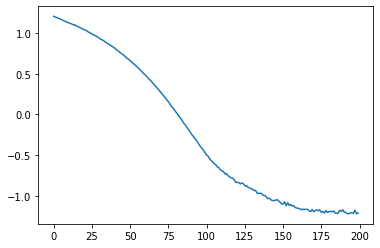

In [95]:
dataset = OneDDataset()
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [96]:
X = np.linspace(-3.,3.,200)
xx_tensor = torch.from_numpy(X).view(-1,1).float()
dist = model(xx_tensor)
yhat = dist.mean.detach().cpu().numpy()[:,0]

In [97]:
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

Weight space dimension: 8.578e+03
computing basis
using T = 64


  0%|          | 0/100 [00:00<?, ?it/s]

In [98]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [99]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(xx_tensor)
    
    marg_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]


    _, z_prior_var = scod_model(xx_tensor, use_prior=True)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(dataset.X)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (dataset.Y - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X.shape),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X.shape),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X.shape),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

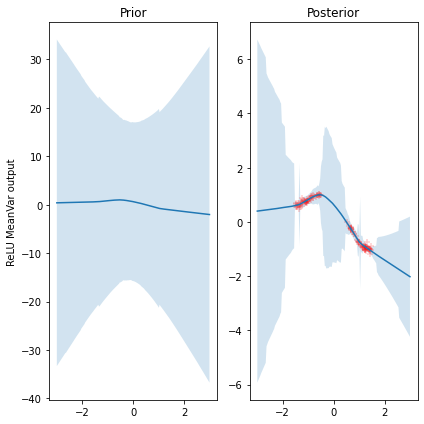

In [100]:
fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

draw_y = True

for i, result in enumerate(results):
    std = np.sqrt(result['total_prior_var'])
    axes[0].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[0].plot(X, draw_y*yhat)
    # axes[i,0].scatter(dataset.X[:,0], draw_y*dataset.Y)
    std = np.sqrt(result['total_var'])
    axes[1].fill_between(X, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
    axes[1].plot(X, draw_y*yhat)
    axes[1].scatter(dataset.X[:,0], draw_y*dataset.Y, marker='+', alpha=0.2, color='red')
    
    axes[0].set_ylabel(result['name'])

axes[0].set_title('Prior')
axes[1].set_title('Posterior')

plt.tight_layout()
#plt.savefig("qualitative_1d.pdf")

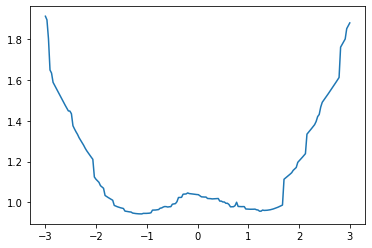

In [87]:
plt.plot(X,std)

# MyCode

## Rotated MNIST dataset

### Download Dataset

In [ ]:
from rotated_mnist import RotatedMNIST
# Create a training dataset of rotated MNIST digits (where digit 2 is used by default)
rotated_mnist_train = RotatedMNIST(split='train')

# Create a validation dataset
rotated_mnist_val = RotatedMNIST(split='val')

# Create an out-of-distribution dataset
rotated_mnist_ood = RotatedMNIST(split='ood')

# Create an out-of-distribution dataset with a different angle
rotated_mnist_ood_angle = RotatedMNIST(split='ood_angle')


### Train and Evaluate Model Without Uncertainty

In [47]:
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from nn_ood.data.rotated_mnist import RotatedMNIST
from torchvision import transforms

In [48]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, gain=5./3)
    if m.__class__.__name__.find('Conv') != -1:
        nn.init.normal_(m.weight, 0.0, 0.02)

In [49]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    model.apply(weight_init)
    
    return model

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = make_model().to(device)

In [51]:
BATCH_SIZE = 16
N_EPOCHS = 10
LEARNING_RATE = 0.001

In [52]:
# Create the data loaders
train_loader = DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [53]:
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [54]:
# Training loop
for epoch in range(N_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    print(f'Validation Loss: {val_loss/len(val_loader)}')


Epoch 1, Loss: 0.27534147578693585
Validation Loss: 0.24117859773910963
Epoch 2, Loss: 0.19117883237293515
Validation Loss: 0.13807913643809466
Epoch 3, Loss: 0.17056767477206985
Validation Loss: 0.17871360583947254
Epoch 4, Loss: 0.16475725611397152
Validation Loss: 0.17228106672947224
Epoch 5, Loss: 0.15773376878900278
Validation Loss: 0.1151881936364449
Epoch 6, Loss: 0.13013453372621825
Validation Loss: 0.1246875666655027
Epoch 7, Loss: 0.14279162600366824
Validation Loss: 0.11808782732830597
Epoch 8, Loss: 0.13484339711653323
Validation Loss: 0.10232469320583802
Epoch 9, Loss: 0.11431794508232987
Validation Loss: 0.11841874697174017
Epoch 10, Loss: 0.1109566256134264
Validation Loss: 0.10755628228474122


In [55]:
# Save the trained model
torch.save(model.state_dict(), "RotatedMNIST_model_basic.pth")

In [56]:
# create a function to evaluate the mean absolute error
def evaluate_mae(model, dataloader):
    model.eval()
    criterion = nn.L1Loss()
    with torch.no_grad():
        mae = 0.0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            mae += criterion(outputs.squeeze(), targets).item()
    return mae / len(dataloader)
mae = evaluate_mae(model, DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE))
print(mae)


0.22565277551229185


### Use SCOD

In [3]:
BATCH_SIZE = 16

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import scod

# Define a CNN model for Rotated MNIST
class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 2)  # Outputting 2 values for SCOD

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model
cnn_model = CNNRegressor()

# Define the distribution layer for SCOD
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()

# add meanvar_dist_layer to the model
cnn_model = nn.Sequential(cnn_model, meanvar_dist_layer)


In [36]:
class CNNRegressorWithUncertainty(nn.Module):
    def __init__(self):
        super(CNNRegressorWithUncertainty, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(64, 2)  # Outputting 2 values: mean and log variance
        
        self.softplus = nn.Softplus()  # Ensure log variance is positive

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Concatenate mean and log variance into a single tensor
        mean = x[:, 0:1]
        log_variance = self.softplus(x[:, 1:2])
        output = torch.cat((mean, log_variance), dim=1)
        
        return output

# Instantiate the model
cnn_model = CNNRegressorWithUncertainty()

mean_loss=18.894283: 100%|██████████| 10/10 [01:37<00:00,  9.71s/it]


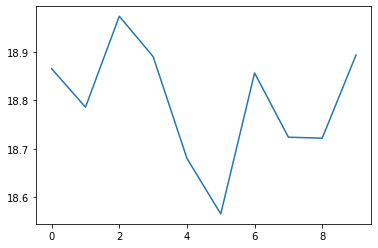

In [30]:
train_dataloader = torch.utils.data.DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
model = cnn_model
losses = []
t = trange(10)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [37]:
for inputs, _ in DataLoader(rotated_mnist_train, batch_size=4):
    mean, log_variance = cnn_model(inputs)
    print("Mean shape:", mean.shape)
    print("Log variance shape:", log_variance.shape)
    break


ValueError: too many values to unpack (expected 2)

In [38]:
cnn_unc_model = scod.SCOD(cnn_model, args={
    'num_eigs': 10,
    'num_samples': 64, # check number of samples  
    'sketch_type': 'srft',
})

Weight space dimension: 2.094e+05


In [32]:
BATCH_SIZE = 16

In [33]:
type(rotated_mnist_train)

rotated_mnist.RotatedMNIST

In [39]:
.process_dataset(rotated_mnist_train, meacnn_unc_modelnvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/5958 [00:00<?, ?it/s]

In [41]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': cnn_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [21]:
for inputs, targets in DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE):
    print(inputs.shape, targets.shape)
    break

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [44]:
loader = DataLoader(rotated_mnist_ood, batch_size=len(rotated_mnist_ood), shuffle=False)

all_images, all_labels = next(iter(loader))

In [46]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(all_images)
    
    marg_dist = meanvar_dist_layer.marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]

    _, z_prior_var = scod_model(all_images, use_prior=True) # from test dataset

    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(all_images)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (all_labels - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(all_images.shape[0]),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(all_images.shape[0]),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(all_images.shape[0]),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(all_images.shape[0]),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

In [23]:
all_images.shape

torch.Size([5958, 1, 28, 28])

In [24]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(all_images, all_labels)

In [25]:
print("Type of dataset object:", type(dataset))

Type of dataset object: <class 'torch.utils.data.dataset.TensorDataset'>


In [26]:
cnn_unc_model.process_dataset(dataset, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/5958 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'shape'

In [49]:
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [55]:
print("Type of dataset object:", type(dataset))

Type of dataset object: <class 'torch.utils.data.dataset.TensorDataset'>


In [56]:
dataset.shape

AttributeError: 'TensorDataset' object has no attribute 'shape'

In [57]:
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/5958 [00:00<?, ?it/s]

C:\Users\Kelyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


AttributeError: 'Independent' object has no attribute 'shape'

In [ ]:
# Instantiate SCOD with the CNN model
scod_model = scod.SCOD(cnn_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

# Process the dataset with SCOD
# Assuming you have your DataLoader `train_dataloader` ready
scod_model.process_dataset(train_loader, meanvar_dist_layer)

In [22]:
X_tensor = torch.tensor(rotated_mnist_train)

ValueError: only one element tensors can be converted to Python scalars

In [16]:
from nn_ood.distributions import GaussianFixedDiagVar

In [17]:
# from nn_ood.posteriors import SCOD
from scod import SCOD

In [18]:
from rotated_mnist import RotatedMNIST

In [ ]:
class ConvEvidentialRegressor(nn.Module):
    def __init__(self):
        super(ConvEvidentialRegressor, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels, Output channels, Kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size, Stride

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 output channels from conv2, image size is 7x7 after pooling
        self.fc2 = nn.Linear(128, 4)  # Output 4 evidential parameters: mu, v, alpha, beta

        # Evidence layer to ensure outputs are positive
        self.evidence = nn.Softplus()

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Split the output into evidential parameters and apply the evidence function
        mu, logv, logalpha, logbeta = torch.split(x, 1, dim=1)
        v = self.evidence(logv) + 1e-5
        alpha = self.evidence(logalpha) + 1 + 1e-5
        beta = self.evidence(logbeta) + 1e-5

        return mu, v, alpha, beta

# Example of creating a model instance
model = ConvEvidentialRegressor()

In [20]:
def make_model():
    model = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(16, 32, 3, 1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 32, 3, 1),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(288, 10),
        nn.ReLU(),
        nn.Linear(10, 2)
    )
    model.apply(weight_init)
    
    return model

In [21]:
# load "RotatedMNIST_model.pth in model
model = make_model().to(device)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(model, meanvar_dist_layer)

  0%|          | 0/10 [00:00<?, ?it/s]

mean_loss=42.769417: 100%|██████████| 10/10 [00:49<00:00,  4.99s/it]


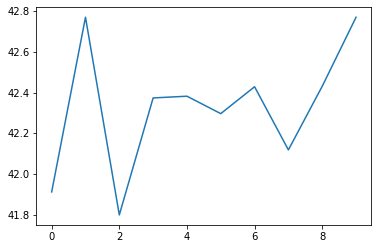

In [36]:
train_dataloader = torch.utils.data.DataLoader(rotated_mnist_train, batch_size=36, shuffle=True,  num_workers=0)
val_loader = torch.utils.data.DataLoader(rotated_mnist_val, batch_size=36, shuffle=False,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()

losses = []
t = trange(10)

for epoch in t:
    model.train()
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            # print("outputs", outputs)
            # print("targets", targets)
            # print("targets shape", targets.shape)
            # loss = criterion(outputs, targets)
            loss = -outputs.log_prob(targets)
            val_loss += loss.mean().item()
    val_loss /= len(val_loader)

plt.plot(losses)

In [25]:
test_loader = torch.utils.data.DataLoader(rotated_mnist_val, batch_size=36, shuffle=True,  num_workers=0)

In [38]:
model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)

In [40]:
outputs

Independent(Normal(loc: torch.Size([24, 1]), scale: torch.Size([24, 1])), 1)

In [41]:
yhat = outputs.mean.detach().cpu().numpy()[:,0]

In [42]:
yhat.shape

(24,)

In [43]:
unc_model = scod.SCOD(model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

Weight space dimension: 1.696e+04


In [44]:
unc_model.process_dataset(val_loader, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/29 [00:00<?, ?it/s]

TypeError: 'DataLoader' object is not subscriptable

In [29]:
# Load your dataset
rotated_mnist_train = RotatedMNIST(split='train')

# Define your model (use the make_model function provided in the script)
model = make_model().to(device)

In [30]:
# Create the data loaders
train_loader = DataLoader(rotated_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# Wrap it with SCOD
dist_fam = GaussianFixedDiagVar().to(device) # Assuming Gaussian distribution for regression
scod_model = SCOD(model, dist_fam).to(device)

TypeError: 'GaussianFixedDiagVar' object is not iterable

In [101]:
scod_model.process_dataset(rotated_mnist_train)

computing basis
using T = 64


100%|██████████| 5958/5958 [00:39<00:00, 149.73it/s]


In [34]:
rotated_mnist_val = RotatedMNIST(split='val')  # Or 'test', if available
val_loader = DataLoader(rotated_mnist_val, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
model.eval()  # Make sure the model is in evaluation mode

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=288, out_features=10, bias=True)
  (10): ReLU()
  (11): Linear(in_features=10, out_features=1, bias=True)
)

In [104]:
with torch.no_grad():
    for inputs, _ in val_loader:
        inputs = inputs.to(device)

        # Since SCOD wrapper expects inputs to have gradient, 
        # enable gradient computation for inputs if not already done
        inputs.requires_grad_(True)
        
        # Get predictions and uncertainty estimates
        prediction, uncertainty = scod_model(inputs)

        # Here, you can process the prediction and uncertainty as needed, for example:
        # Convert prediction and uncertainty to numpy or CPU tensors for further processing
        prediction = prediction.cpu().numpy()
        uncertainty = uncertainty.cpu().numpy()
        
        # Example of handling the results
        print(f"Prediction: {prediction}, Uncertainty: {uncertainty}")

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### Use Deep Evidential Regression

In [5]:
#Required losses to make use of Evidential

def NIG_NLL(y, gamma, v, alpha, beta, device, reduce=True):
    twoBlambda = 2*beta*(1+v)

    nll = 0.5*torch.log(torch.tensor(np.pi).to(device)/v)  \
        - alpha*torch.log(twoBlambda+1e-5)  \
        + (alpha+0.5) * torch.log(v*(y-gamma)**2 + twoBlambda+1e-5)  \
        + torch.lgamma(alpha)  \
        - torch.lgamma(alpha+0.5)

    return nll.mean() if reduce else nll

def KL_NIG(mu1, v1, a1, b1, mu2, v2, a2, b2):
    KL = 0.5*(a1-1)/b1 * (v2*torch.square(mu2-mu1))  \
        + 0.5*v2/v1  \
        - 0.5*torch.log(torch.abs(v2)/torch.abs(v1))  \
        - 0.5 + a2*torch.log(b1/b2)  \
        - (torch.lgamma(a1) - torch.lgamma(a2))  \
        + (a1 - a2)*torch.digamma(a1)  \
        - (b1 - b2)*a1/b1
    return KL

def NIG_Reg(y, gamma, v, alpha, beta, device, omega=0.01, reduce=True, kl=False):
    error = torch.abs(y-gamma).detach()
    if kl:
        kl = KL_NIG(gamma, v, alpha, beta, gamma, device, omega, 1+omega, beta)
        reg = error*kl
    else:
        evi = 2*v+(alpha) #+ 1/beta
        reg = error*evi

    return (reg).mean() if reduce else reg

def EvidentialRegression(y_true, gamma, v, alpha, beta, device ,coef=1.0,reduce=True):
    loss_nll = NIG_NLL(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    loss_reg = NIG_Reg(y_true, gamma, v, alpha, beta, device, reduce = reduce)
    return loss_nll + coef * loss_reg

In [8]:
class ConvEvidentialRegressor(nn.Module):
    def __init__(self):
        super(ConvEvidentialRegressor, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels, Output channels, Kernel size
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # Kernel size, Stride

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 64 output channels from conv2, image size is 7x7 after pooling
        self.fc2 = nn.Linear(128, 4)  # Output 4 evidential parameters: mu, v, alpha, beta

        # Evidence layer to ensure outputs are positive
        self.evidence = nn.Softplus()

    def forward(self, x):
        # Apply convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(-1, 64 * 7 * 7)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Split the output into evidential parameters and apply the evidence function
        mu, logv, logalpha, logbeta = torch.split(x, 1, dim=1)
        v = self.evidence(logv) + 1e-5
        alpha = self.evidence(logalpha) + 1 + 1e-5
        beta = self.evidence(logbeta) + 1e-5

        return mu, v, alpha, beta

# Example of creating a model instance
model = ConvEvidentialRegressor()

Epoch 20, Train Loss: 1.3810, Val Loss: 1.3439: 100%|██████████| 20/20 [02:47<00:00,  8.37s/it]


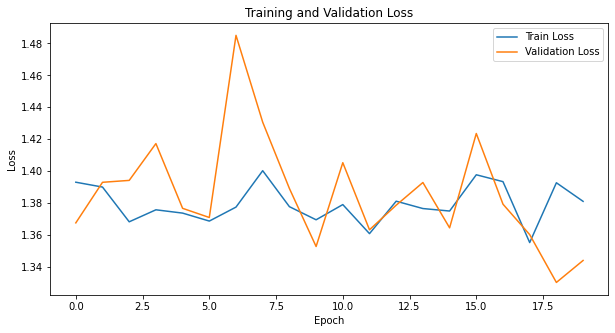

In [19]:
from torch.utils.data import DataLoader
from tqdm import trange
import torch.nn.functional as F

train_dataloader = DataLoader(rotated_mnist_train, batch_size=36, shuffle=True)
val_dataloader = DataLoader(rotated_mnist_val, batch_size=36, shuffle=False)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
losses = []
val_losses = []
t = trange(20)

for epoch in t:
    epoch_loss = 0.0
    model.train()
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        gamma_s, v_s, alpha_s, beta_s = model(inputs)
        loss = EvidentialRegression(targets, gamma_s, v_s, alpha_s, beta_s, device='cpu', coef=0.2)

        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    # Validation loop
    val_epoch_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, targets in val_dataloader:
            gamma_s, v_s, alpha_s, beta_s = model(inputs)
            val_loss = EvidentialRegression(targets, gamma_s, v_s, alpha_s, beta_s, device='cpu', coef=0.2)
            val_epoch_loss += val_loss.item()

    val_epoch_loss /= len(val_dataloader)
    val_losses.append(val_epoch_loss)

    t.set_description(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}")

# Plotting the training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()  # Set the model to evaluation mode
test_loader = DataLoader(rotated_mnist_ood_angle, batch_size=32, shuffle=False)
total_nll = 0.0
total_count = 0

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Get model predictions
        gamma, v, alpha, beta = model(inputs)
        
        # Compute the predictive variance (or standard deviation)
        # Here we need the correct formula based on your model's output
        # This is a placeholder and needs to be adjusted based on your model
        sigma_squared = beta / (v * (alpha - 1))
        sigma = torch.sqrt(sigma_squared)
        
        # Compute the NLL
        nll = 0.5 * torch.log(2 * np.pi * sigma_squared) + ((targets - gamma) ** 2) / (2 * sigma_squared)
        total_nll += nll.sum().item()  # Sum NLL for batch and add to total
        total_count += inputs.size(0)  # Count total number of datapoints

average_nll = total_nll / total_count
print("Average NLL on OOD Test Set:", average_nll)


Average NLL on OOD Test Set: 152.7361945810244


## Wine

### Load datasets

In [2]:
red_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')
white_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=';')

### Use Deep Evidential Regression

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import evidential_deep_learning as edl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Splitting the data into features and target
# X = red_wine.drop('quality', axis=1).values
# y = red_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow
X_train = red_wine.drop('quality', axis=1).values
y_train = red_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow
X_test = white_wine.drop('quality', axis=1).values
y_test = white_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow

# Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the TensorFlow model
def build_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(100, activation="relu"),  # 100 units as per the paper
        tf.keras.layers.Dense(100, activation="relu"),  # Second layer with 100 units
        edl.layers.DenseNormalGamma(1),  # Output layer for evidential regression
    ])
    return model

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Create the model instance
model = build_model(input_shape=(X_train_scaled.shape[1],))


In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-4), loss=EvidentialRegressionLoss)

In [42]:
model.fit(X_train_scaled, y_train, batch_size=32, epochs=100, validation_split=0.1)

Epoch 1/100
45/45 [==============================] - 5s 17ms/step - loss: 4.4327 - val_loss: 3.3448
Epoch 2/100
45/45 [==============================] - 0s 7ms/step - loss: 3.0189 - val_loss: 2.6686
Epoch 3/100
45/45 [==============================] - 0s 6ms/step - loss: 2.3278 - val_loss: 1.9952
Epoch 4/100
45/45 [==============================] - 0s 7ms/step - loss: 1.9045 - val_loss: 1.7891
Epoch 5/100
45/45 [==============================] - 0s 6ms/step - loss: 1.7412 - val_loss: 1.6999
Epoch 6/100
45/45 [==============================] - 0s 6ms/step - loss: 1.6231 - val_loss: 1.6103
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 1.5255 - val_loss: 1.5552
Epoch 8/100
45/45 [==============================] - 0s 6ms/step - loss: 1.4298 - val_loss: 1.4510
Epoch 9/100
45/45 [==============================] - 0s 7ms/step - loss: 1.3429 - val_loss: 1.3690
Epoch 10/100
45/45 [==============================] - 1s 13ms/step - loss: 1.2726 - val_loss: 1.3243
Epoch 1

In [43]:
y_pred = model.predict(X_test_scaled)

154/154 [==============================] - 1s 4ms/step


In [44]:
mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
mu = mu[:, 0]
var = np.sqrt(beta / (v * (alpha - 1)))

In [45]:
from sklearn.metrics import mean_squared_error
# RMSE Calculation
rmse = np.sqrt(mean_squared_error(y_test, mu))
print(f"RMSE: {rmse}")

# Negative Log-Likelihood Calculation
def gaussian_nll(y_true, y_pred_mu, y_pred_var):
    nll = 0.5 * np.log(2 * np.pi * y_pred_var) + 0.5 * (((y_true - y_pred_mu) ** 2) / y_pred_var)
    return np.mean(nll)

nll = gaussian_nll(y_test, mu, var)
print(f"Negative Log-Likelihood: {nll}")

RMSE: 0.93451327085495
Negative Log-Likelihood: 4.31942892074585


In [17]:
mu = y_pred[:, 0] # mean value predicted by the model

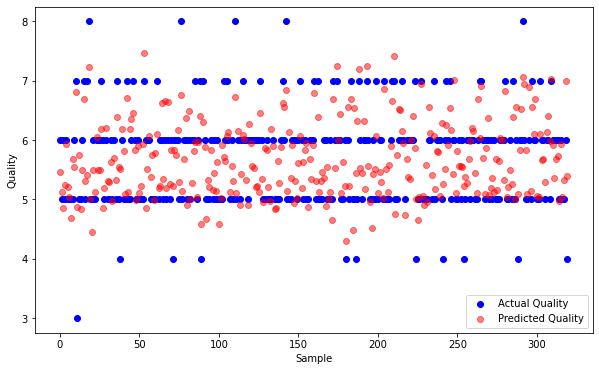

In [461]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual Quality')
plt.scatter(range(len(mu)), mu, color='red', label='Predicted Quality', alpha=0.5)
plt.xlabel('Sample')
plt.ylabel('Quality')
plt.legend()
plt.show()

In [462]:
def plot_uncertainty(X_train, y_train, X_test, y_test, model):
    # Predict the evidential outputs using the model
    y_pred = model.predict(X_test_scaled)
    
    # Split the predictions into components
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    var = np.minimum(var, 1e3)[:, 0]  # for visualization, cap the variance
    
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test
    
    # Sort the test data by the predicted mean for nicer plots
    sorted_indices = np.argsort(mu)
    mu_sorted = mu[sorted_indices]
    var_sorted = var[sorted_indices]
    y_test_sorted = y_test_np[sorted_indices]
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(y_test_sorted)), y_test_sorted, s=2., color='blue', zorder=0, label="True Quality")
    plt.scatter(range(len(mu_sorted)), mu_sorted, s=2., color='red', zorder=1, label="Predicted Quality")
    plt.fill_between(range(len(mu_sorted)), mu_sorted + 1.96 * var_sorted, mu_sorted - 1.96 * var_sorted, alpha=0.2, color='red', label="Predicted Std Dev")
    plt.xlabel("Sorted Test Data Points")
    plt.ylabel("Quality")
    plt.title("Wine Quality Predictions with Uncertainty")
    plt.legend()
    plt.show()


10/10 [==============================] - 0s 1ms/step


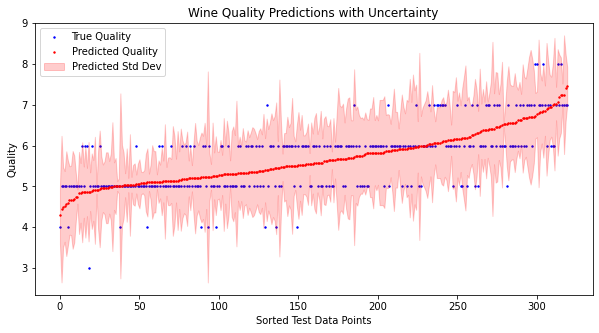

In [463]:
plot_uncertainty(X_train, y_train, X_test, y_test, model)

In [464]:
def plot_uncertainty_vs_error(X_test_scaled, y_test, model):
    # Predict the evidential outputs using the model
    y_pred = model.predict(X_test_scaled)
    
    # Split the predictions into components
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0].numpy()  # Convert to NumPy array and get the predicted mean
    var = np.sqrt(beta / (v * (alpha - 1))) # Convert to NumPy array and get the predicted variance
    var = np.minimum(var, 1e3)[:, 0]  # for visualization, cap the variance
    
    # Get the true quality scores as NumPy array for indexing
    y_test_np = y_test.numpy() if isinstance(y_test, tf.Tensor) else y_test

    # transform y_test_np to 1D array
    y_test_np = y_test_np.flatten()

    pred_error = np.abs(y_test_np - mu)

    # Plot the correlation between the predicted standard deviation var and the prediction error (|y_test_np - mu|)
    plt.figure(figsize=(6, 6))
    plt.scatter(var, pred_error, s=2., color='blue', label="Uncertainty vs. Error")
    plt.xlabel("Predicted Standard Deviation")
    plt.ylabel("Prediction Error")
    plt.title("Uncertainty vs. Error")
    plt.show()

    return (var, pred_error)

10/10 [==============================] - 0s 1ms/step


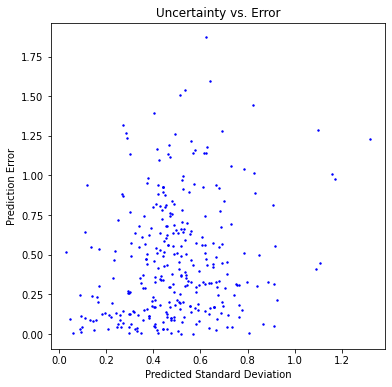

In [465]:
var, pred_error = plot_uncertainty_vs_error(X_test_scaled, y_test, model)

In [468]:
# compute the correlation between var and pred_error
print(pearsonr(var,pred_error))

(0.21159002873170707, 0.00013701761596873472)


In [473]:
nll_loss = 0.5 * np.log(2 * torch.pi * var) + (y_test - mu) ** 2 / (2 * var)
nll_loss = nll_loss.mean()

print(f'Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: {nll_loss.item()}')

Negative Log Likelihood Loss on the Test Set of the Wine Dataset using Evidential Deep Learning: 1.9810665845870972


### Use Scod on full dataset

In [368]:
red_wine = red_wine.sample(frac=0.1).reset_index(drop=True)

In [369]:
features = red_wine.drop('quality', axis=1).values
targets = red_wine['quality'].values.reshape(-1, 1)

In [370]:
X_tensor = torch.tensor(features, dtype=torch.float32)
y_tensor = torch.tensor(targets, dtype=torch.float32)

In [371]:
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

In [372]:
dataset_size = dataset.tensors[0].shape[1]

In [373]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(dataset_size, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=1.065550: 100%|██████████| 200/200 [00:02<00:00, 70.16it/s]


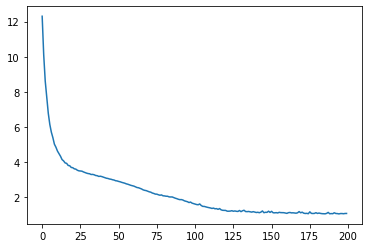

In [374]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [375]:
dist = model(X_tensor)
yhat = dist.mean.detach().cpu().numpy()[:,0]

In [376]:
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64,
    'sketch_type': 'srft',
})

Weight space dimension: 9.218e+03


In [377]:
meanvar_unc_model.process_dataset(dataset, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/160 [00:00<?, ?it/s]

C:\Users\Kelyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [378]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [379]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(X_tensor) 
    
    marg_dist = meanvar_dist_layer.marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]

    _, z_prior_var = scod_model(X_tensor, use_prior=True) # from full dataset
    print("z_mean shape:", z_mean.shape)
    print("z_prior_var shape:", z_prior_var.shape)
    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(X_tensor)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (y_tensor - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X_tensor.shape[0]),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

z_mean shape: torch.Size([160, 2])
z_prior_var shape: torch.Size([160, 2])


In [380]:
features_list = red_wine.columns[:-1].tolist()

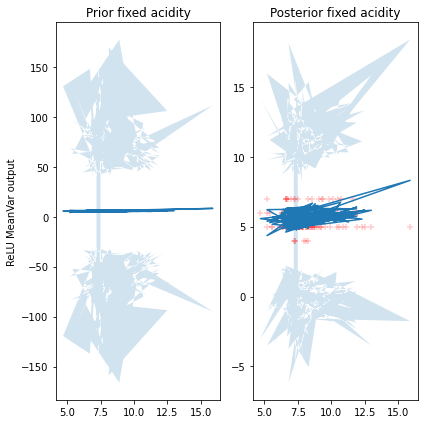

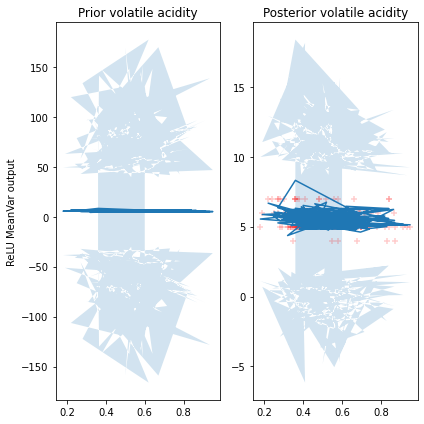

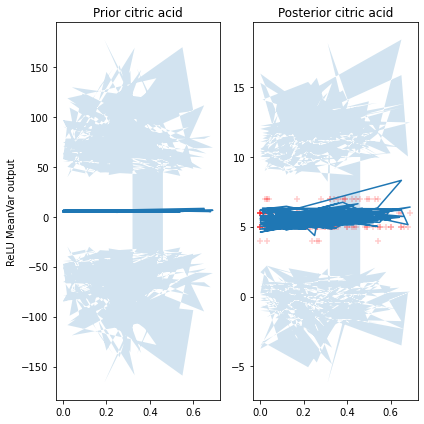

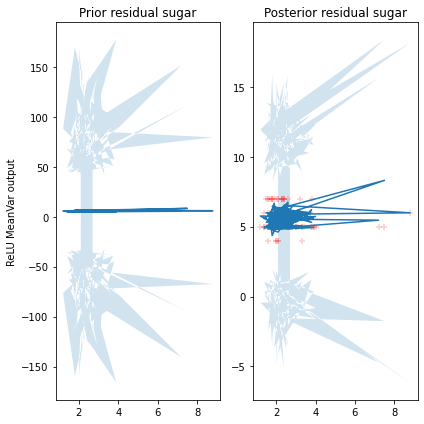

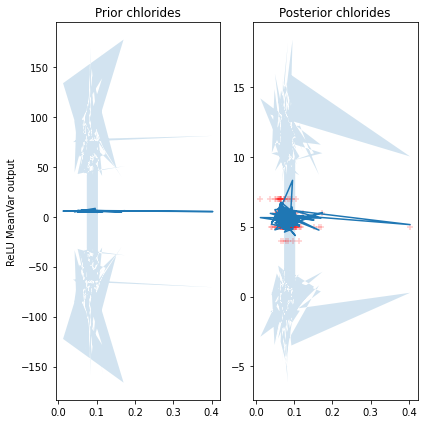

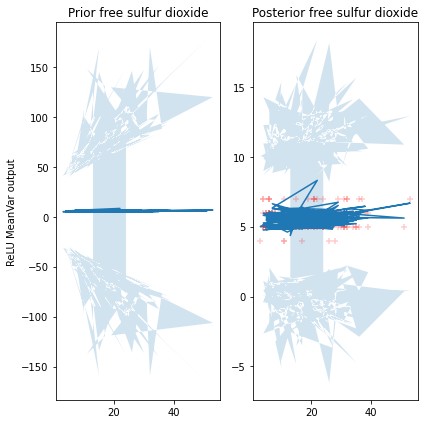

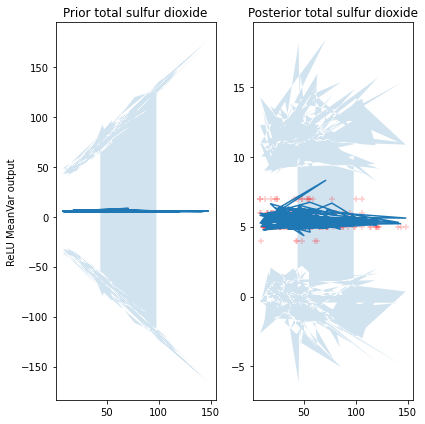

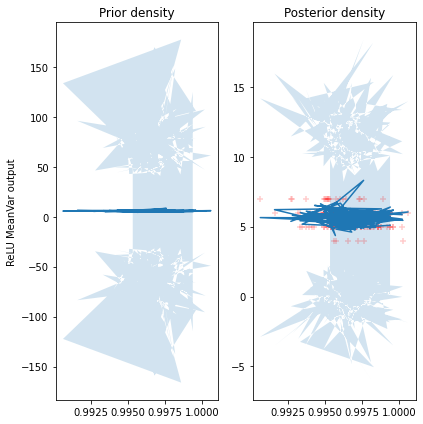

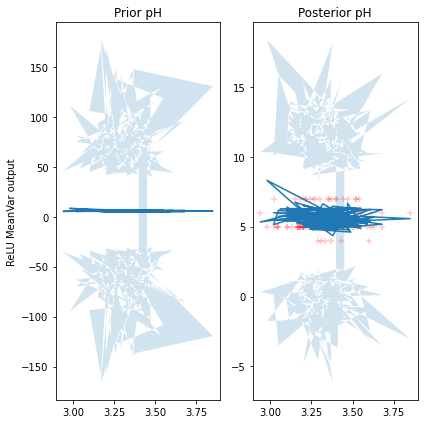

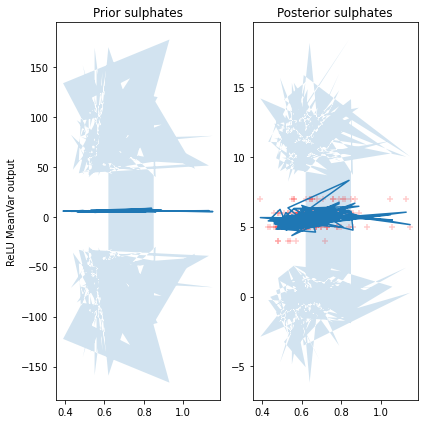

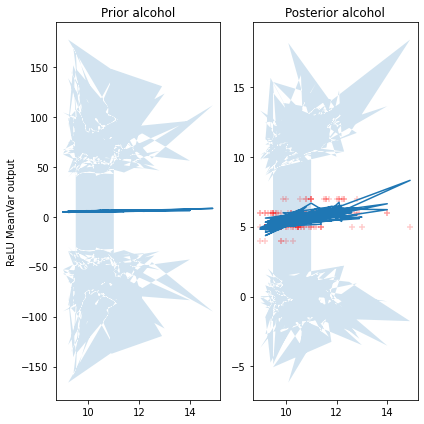

In [381]:
for i in range(len(features_list)):
    X_1dd = X_tensor[:, i]
    feature = features_list[i]
    fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_prior_var'])
        axes[0].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[0].plot(X_1dd, draw_y*yhat)
        std = np.sqrt(result['total_var'])
        axes[1].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[1].plot(X_1dd, draw_y*yhat)
        axes[1].scatter(X_1dd, draw_y*y_tensor, marker='+', alpha=0.2, color='red')
        
        axes[0].set_ylabel(result['name'])

    axes[0].set_title('Prior ' + feature)
    axes[1].set_title('Posterior '+ feature)

    plt.tight_layout()

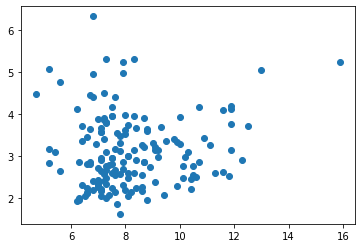

In [383]:
plt.scatter(X_tensor[:, 0],std)

### Use SCOD on test set

In [3]:
# use red wine for training and white wine for testing

In [4]:
features = red_wine.drop('quality', axis=1).values
targets = red_wine['quality'].values.reshape(-1, 1)

In [5]:
# X_tensor = torch.tensor(features, dtype=torch.float32)
# y_tensor = torch.tensor(targets, dtype=torch.float32)
X_tensor_train = torch.tensor(features, dtype=torch.float32)
y_tensor_train = torch.tensor(targets, dtype=torch.float32)

In [6]:
features = white_wine.drop('quality', axis=1).values
targets = white_wine['quality'].values.reshape(-1, 1)
X_tensor_test = torch.tensor(features, dtype=torch.float32)
y_tensor_test = torch.tensor(targets, dtype=torch.float32)

In [7]:
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

NameError: name 'X_tensor' is not defined

In [ ]:
# X_tensor_train = X_tensor[:int(0.8*len(X_tensor))]
# y_tensor_train = y_tensor[:int(0.8*len(y_tensor))]
# X_tensor_test = X_tensor[int(0.8*len(X_tensor)):]
# y_tensor_test = y_tensor[int(0.8*len(y_tensor)):]

In [8]:
dataset_train = torch.utils.data.TensorDataset(X_tensor_train, y_tensor_train)

In [9]:
dataset_test = torch.utils.data.TensorDataset(X_tensor_test, y_tensor_test)

In [10]:
dataset_size = dataset_train.tensors[0].shape[1]

In [11]:
meanvar_model = torch.nn.Sequential(
    torch.nn.Linear(dataset_size, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 2)
)
meanvar_dist_layer = scod.distributions.NormalMeanDiagVarParamLayer()
model = torch.nn.Sequential(meanvar_model, meanvar_dist_layer)

mean_loss=0.940207: 100%|██████████| 200/200 [00:56<00:00,  3.51it/s]


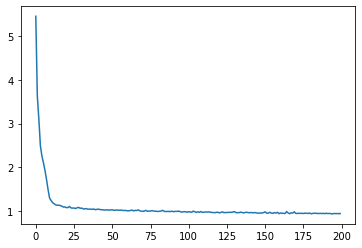

In [12]:
train_dataloader = torch.utils.data.DataLoader(dataset_train, batch_size=36, shuffle=True,  num_workers=0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
t = trange(200)

for epoch in t:
    epoch_loss = 0.
    for (inputs, targets) in train_dataloader:
        optimizer.zero_grad()

        dist = model(inputs)
        loss = -dist.log_prob(targets)

        mean_loss = loss.mean()

        mean_loss.backward()

        epoch_loss += mean_loss

        optimizer.step()

    epoch_loss /= len(train_dataloader)

    t.set_description("mean_loss=%02f"%epoch_loss.item())
    losses.append(epoch_loss.item())

plt.plot(losses)

In [13]:
dist = model(X_tensor_test)
yhat = dist.mean.detach().cpu().numpy()[:,0]

In [14]:
# check parameters of meanvar_unc_model
meanvar_unc_model = scod.SCOD(meanvar_model, args={
    'num_eigs': 10,
    'num_samples': 64, # check number of samples  
    'sketch_type': 'srft',
})

Weight space dimension: 1.150e+04


In [15]:
meanvar_unc_model.process_dataset(dataset_test, meanvar_dist_layer)

computing basis
using T = 64


  0%|          | 0/4898 [00:00<?, ?it/s]

C:\Users\Kelyan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\amp\autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [16]:
settings = [
    {   
        'name': 'ReLU MeanVar output',
        'model': meanvar_unc_model,
        'dist_layer': meanvar_dist_layer,
    },
]

In [17]:
results = []
for setting in settings:
    scod_model = setting['model']
    
    z_mean, z_var = scod_model(X_tensor_test) 
    
    marg_dist = meanvar_dist_layer.marginalize_gaussian(z_mean, z_var)
    z_var = z_var[:,:1]

    _, z_prior_var = scod_model(X_tensor_test, use_prior=True) # from test dataset

    marg_prior_dist = setting['dist_layer'].marginalize_gaussian(z_mean, z_prior_var)
    z_prior_var = z_prior_var[:,:1]

    z_mean_dataset, _ = scod_model(X_tensor_test)
    z_mean_dataset = z_mean_dataset[:,:1]
    sq_err = (y_tensor_test - z_mean_dataset)**2

    result = {
        'name': setting['name'],
        'z_vars': z_var.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'total_var': marg_dist.variance.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'prior_z_vars': z_prior_var.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'total_prior_var': marg_prior_dist.variance.detach().cpu().numpy().reshape(X_tensor_test.shape[0]),
        'sq_err' : sq_err.detach().cpu().numpy()
    }
    
    results.append(result)

In [18]:
y_tensor_test.detach().numpy().shape

(4898, 1)

In [27]:
z_mean_dataset

tensor([[5.3119],
        [5.2031],
        [5.5017],
        ...,
        [4.8816],
        [6.2059],
        [5.8714]], grad_fn=<SliceBackward0>)

In [26]:
z_mean_dataset.detach().numpy()

array([[5.311862 ],
       [5.2030697],
       [5.5016513],
       ...,
       [4.8815513],
       [6.2058787],
       [5.8714046]], dtype=float32)

In [22]:
from sklearn.metrics import mean_squared_error
# RMSE Calculation
rmse = np.sqrt(mean_squared_error(y_tensor_test.detach().numpy(), z_mean_dataset.detach().numpy()))
print(f"RMSE: {rmse}")

RMSE: 0.8955754637718201


In [23]:
z_var

tensor([[203.4316],
        [ 97.5469],
        [ 25.4238],
        ...,
        [ 23.5117],
        [ 55.4229],
        [152.3765]], grad_fn=<SliceBackward0>)

In [25]:
# Negative Log-Likelihood Calculation
def gaussian_nll(y_true, y_pred_mu, y_pred_var):
    nll = 0.5 * np.log(2 * np.pi * y_pred_var) + 0.5 * (((y_true - y_pred_mu) ** 2) / y_pred_var)
    return np.mean(nll)

nll = gaussian_nll(y_tensor_test.detach().numpy(), z_mean_dataset.detach().numpy(), z_var.detach().numpy())
print(f"Negative Log-Likelihood: {nll}")

Negative Log-Likelihood: 3.07051420211792


In [ ]:
# Compute MSE


In [35]:
##### Computing NLL Loss
for i, result in enumerate(results):
        variance = result['total_var']
        # transform variance to a tensor
        variance = torch.tensor(variance)
        nll_loss = 0.5 * torch.log(2 * torch.pi * variance) + (y_tensor_test - yhat) ** 2 / (2 * variance)
        nll_loss = nll_loss.mean()

print(f'Negative Log Likelihood Loss on the Test Set of the Wine Dataset using SCOD: {nll_loss.item()}')

Negative Log Likelihood Loss on the Test Set of the Wine Dataset using SCOD: 2.734239339828491


In [404]:
features_list = red_wine.columns[:-1].tolist()

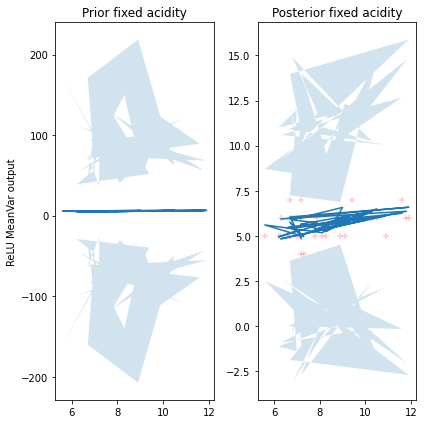

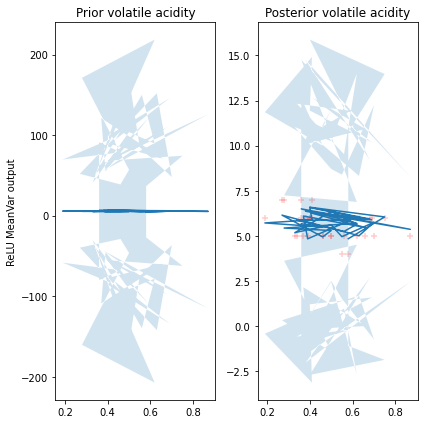

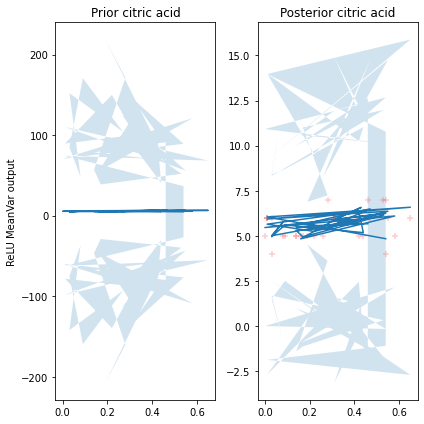

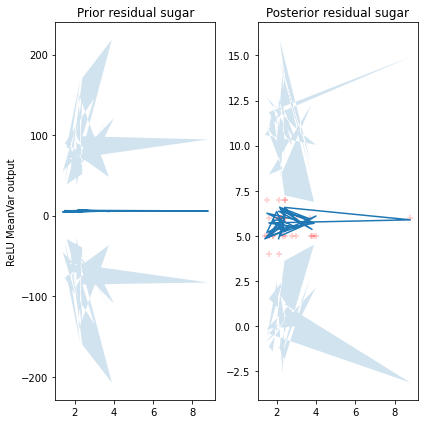

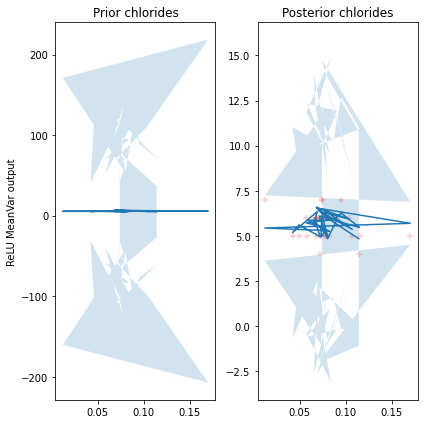

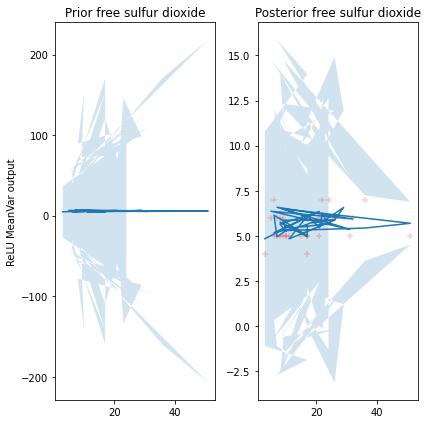

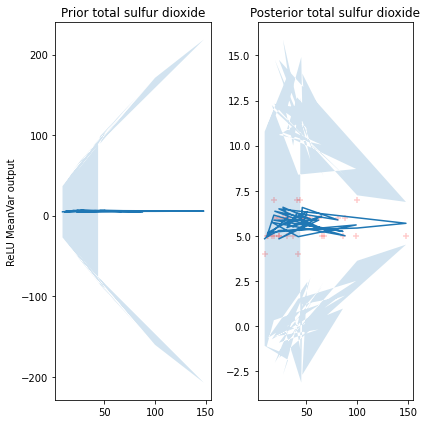

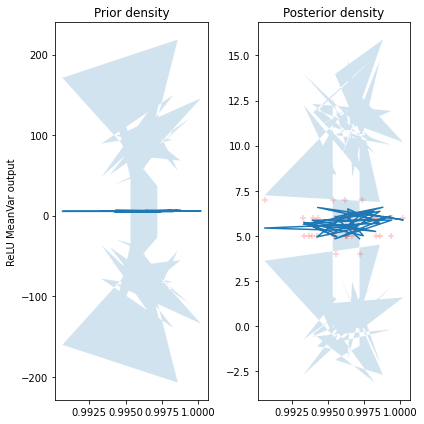

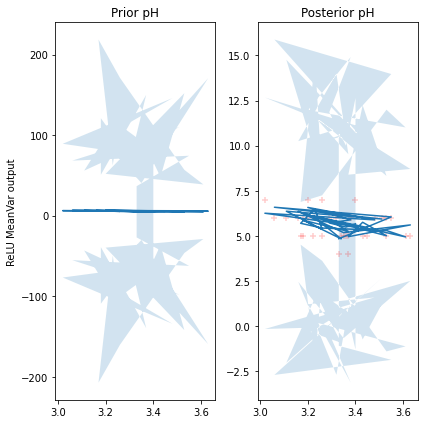

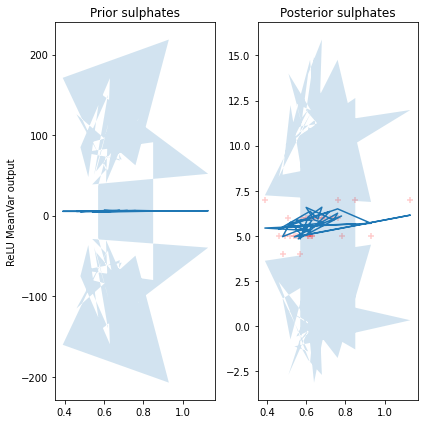

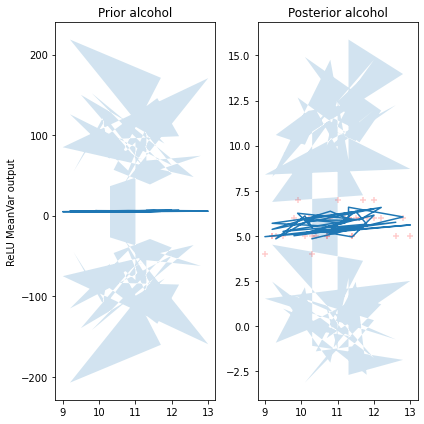

In [406]:
for i in range(len(features_list)):
    X_1dd = X_tensor_test[:, i]
    feature = features_list[i]
    fig, axes = plt.subplots(len(results), 2, figsize=[6,6])

    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_prior_var'])
        axes[0].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[0].plot(X_1dd, draw_y*yhat)
        std = np.sqrt(result['total_var'])
        axes[1].fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        axes[1].plot(X_1dd, draw_y*yhat)
        axes[1].scatter(X_1dd, draw_y*y_tensor_test, marker='+', alpha=0.2, color='red')
        
        axes[0].set_ylabel(result['name'])

    axes[0].set_title('Prior ' + feature)
    axes[1].set_title('Posterior '+ feature)

    plt.tight_layout()

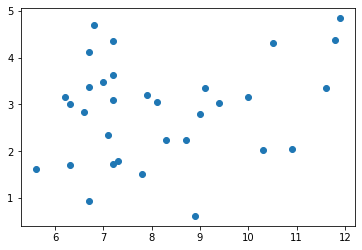

In [408]:
plt.scatter(X_tensor_test[:, 0], np.sqrt(result['total_var']))

Text(0.5, 1.0, 'Quality vs. Uncertainty')

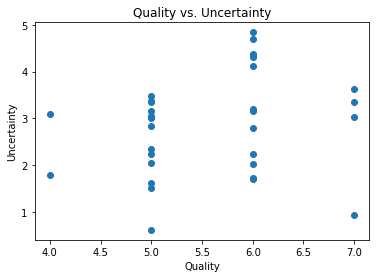

In [416]:
plt.scatter(y_tensor_test, np.sqrt(result['total_var']))
# set x label
plt.xlabel('Quality')
# set y label
plt.ylabel('Uncertainty')
# set title
plt.title('Quality vs. Uncertainty')
# draw a curve that represents the mean of the uncertainty accross the quality

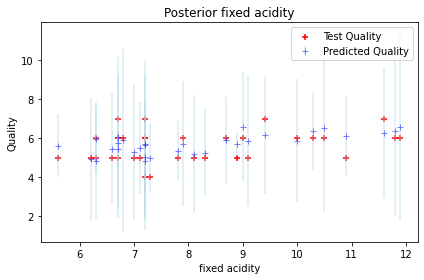

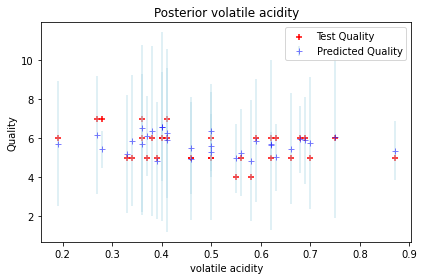

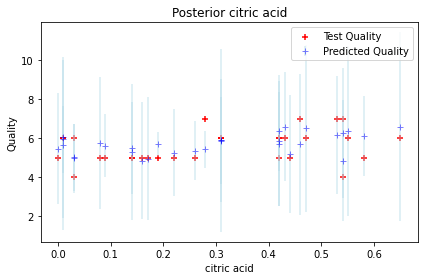

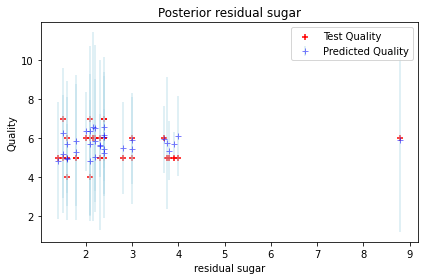

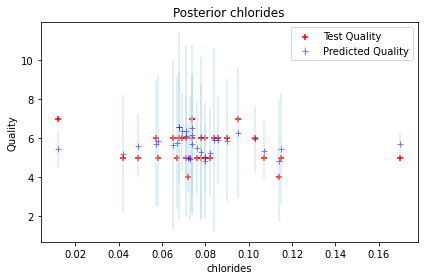

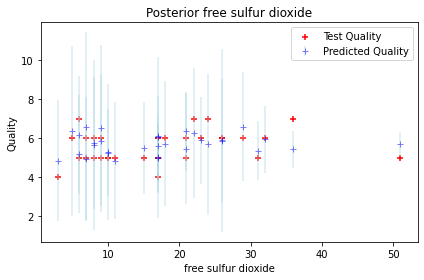

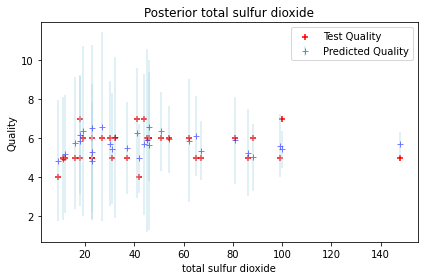

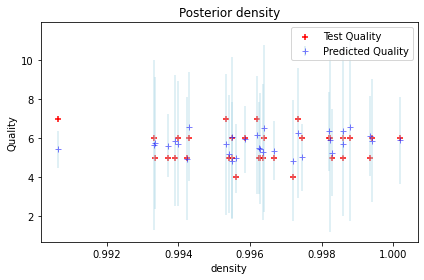

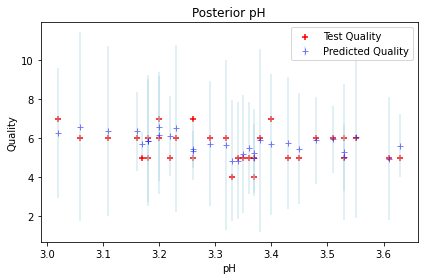

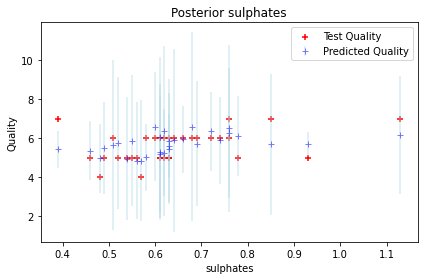

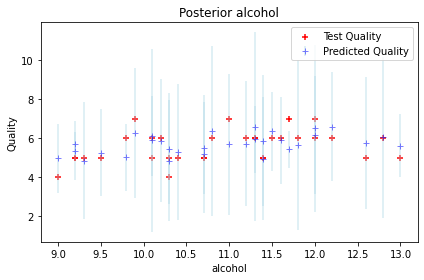

In [435]:
for i in range(len(features_list)):
    # create a plot
    fig, ax = plt.subplots()
    X_1dd = X_tensor_test[:, i]
    feature = features_list[i]
    draw_y = True

    for i, result in enumerate(results):
        std = np.sqrt(result['total_var'])
        # ax.fill_between(X_1dd, draw_y*yhat + 1.92*std, draw_y*yhat - 1.92*std, alpha=0.2)
        # use std as the error bar for each point yhat
        # ax.scatter(X_1dd, draw_y*yhat, yerr=std, marker="+", color="blue", label="Predicted Quality")
        ax.errorbar(X_1dd, yhat, yerr=std, fmt='+', color='blue', alpha = 0.5, ecolor='lightblue',label='Predicted Quality')
        ax.scatter(X_1dd, draw_y*y_tensor_test, marker='+', color='red', label = "Test Quality")
    ax.set_title('Posterior '+ feature)
    # set y label
    ax.set_ylabel('Quality')
    ax.set_xlabel(feature)
    plt.legend()

    plt.tight_layout()

In [441]:
y_tensor_test = y_tensor_test.flatten()

C:\Users\Kelyan\AppData\Local\Temp\ipykernel_23024\1682921081.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yhat = torch.tensor(yhat)


(0.003224842845158532, 0.9860244240068402)


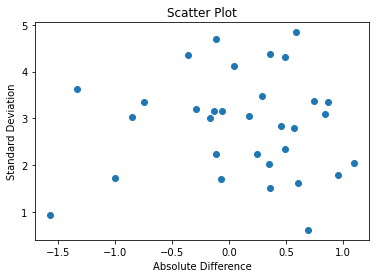

In [451]:
for i, result in enumerate(results):
        std = np.sqrt(result['total_var'])
        # Calculate the absolute difference between yhat and y_tensor_test
        # transform y_tensor_test to 1D array
        # transform yhat to a tensor
        yhat = torch.tensor(yhat)
        abs_diff = yhat - y_tensor_test
        # Plot the scatter plot
        # compute correlation between abs_diff and std
        corr = pearsonr(abs_diff, std)
        print(corr)
        plt.scatter(abs_diff, std)
        plt.xlabel('Absolute Difference')
        plt.ylabel('Standard Deviation')
        plt.title('Scatter Plot')
        plt.show()


### L1 & L2 Model

In [46]:
X_train = red_wine.drop('quality', axis=1).values
y_train = red_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow
X_test = white_wine.drop('quality', axis=1).values
y_test = white_wine['quality'].values.reshape(-1, 1)  # Regression targets must be 2D for TensorFlow

y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [48]:
from tensorflow.keras import regularizers
def build_l1_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l1(0.01)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Build the L2 regularized model (Ridge)
def build_l2_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(100, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    return model

# Assume X_train_scaled and y_train are defined as per your dataset
input_shape = X_train.shape[1:]
l1_model = build_l1_model(input_shape)
l2_model = build_l2_model(input_shape)

In [50]:
l1_model.compile(optimizer='adam', loss='mean_squared_error')
l2_model.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
l1_model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=0)
l2_model.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=0)

In [52]:
y_pred_l1 = l1_model.predict(X_test).flatten() 
y_pred_l2 = l2_model.predict(X_test).flatten()

154/154 [==============================] - 1s 3ms/step


In [53]:
rmse_l1 = np.sqrt(mean_squared_error(y_test, y_pred_l1))
rmse_l2 = np.sqrt(mean_squared_error(y_test, y_pred_l2))
print(f"RMSE for L1 Model: {rmse_l1}")
print(f"RMSE for L2 Model: {rmse_l2}")

RMSE for L1 Model: 0.9470463395118713
RMSE for L2 Model: 0.9520792961120605


In [54]:
def simplified_gaussian_nll(y_true, y_pred, assumed_sigma=1.0):
    # Using a constant assumed_sigma because L1 and L2 do not output variance
    nll = 0.5 * np.log(2 * np.pi * assumed_sigma ** 2) + ((y_true - y_pred) ** 2) / (2 * assumed_sigma ** 2)
    return np.mean(nll)

# Assume some static variance, for example, assumed_sigma = 1.0
nll_l1 = simplified_gaussian_nll(y_test, y_pred_l1, assumed_sigma=1.0)
nll_l2 = simplified_gaussian_nll(y_test, y_pred_l2, assumed_sigma=1.0)
print(f"Simplified NLL for L1 Model: {nll_l1}")
print(f"Simplified NLL for L2 Model: {nll_l2}")

Simplified NLL for L1 Model: 1.5123705863952637
Simplified NLL for L2 Model: 1.5363266468048096


### Auto-Encoder Style Model

In [56]:
from tensorflow.keras import layers

In [57]:
def build_regression_autoencoder(input_shape):
    # Encoder
    encoder = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(100, activation='relu'),
        layers.Dense(50, activation='relu')  # Encoded representation
    ])
    
    # Decoder for regression output
    decoder = tf.keras.Sequential([
        layers.Dense(100, activation='relu'),
        layers.Dense(1)  # Regression output
    ])
    
    # Complete autoencoder model
    autoencoder_input = layers.Input(shape=input_shape)
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(inputs=autoencoder_input, outputs=decoded)
    
    return autoencoder

In [58]:
input_shape = (X_train.shape[1],)
regression_autoencoder = build_regression_autoencoder(input_shape)

In [59]:
# Compile the model
regression_autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
regression_autoencoder.fit(X_train, y_train, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
45/45 [==============================] - 3s 13ms/step - loss: 2.1230 - val_loss: 0.6482
Epoch 2/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5602 - val_loss: 0.6355
Epoch 3/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5268 - val_loss: 0.5466
Epoch 4/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5707 - val_loss: 0.6598
Epoch 5/100
45/45 [==============================] - 0s 6ms/step - loss: 0.6630 - val_loss: 0.6068
Epoch 6/100
45/45 [==============================] - 0s 5ms/step - loss: 0.5124 - val_loss: 0.6017
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5119 - val_loss: 0.5859
Epoch 8/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5119 - val_loss: 0.5819
Epoch 9/100
45/45 [==============================] - 0s 5ms/step - loss: 0.4963 - val_loss: 0.5490
Epoch 10/100
45/45 [==============================] - 0s 6ms/step - loss: 0.5483 - val_loss: 0.5809
Epoch 11

In [60]:
y_pred_autoencoder = regression_autoencoder.predict(X_test).flatten()

154/154 [==============================] - 1s 3ms/step


In [61]:
rmse_autoencoder = np.sqrt(mean_squared_error(y_test, y_pred_autoencoder))
print(f"RMSE for Autoencoder Model: {rmse_autoencoder}")

RMSE for Autoencoder Model: 1.0856589078903198


### Mutual Informations

In [62]:
from sklearn.feature_selection import mutual_info_regression

In [66]:
X_train = red_wine.drop('quality', axis=1)
y_train = red_wine['quality']
X_test = white_wine.drop('quality', axis=1)
y_test = white_wine['quality']

# y_train = y_train.astype(np.float32)
# y_test = y_test.astype(np.float32)

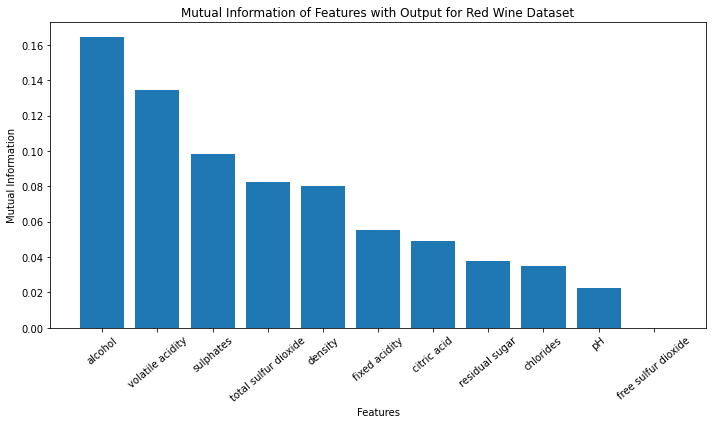

In [79]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.xticks(range(len(mi_scores)), mi_scores.index.to_list(), rotation=40)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of Features with Output for Red Wine Dataset')
plt.tight_layout()
plt.show()


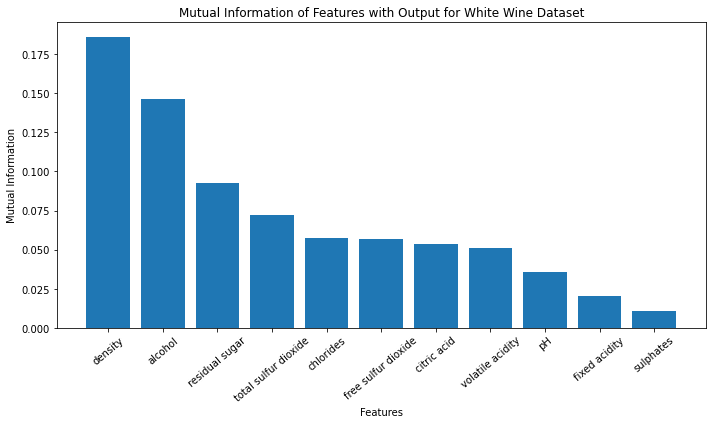

In [80]:
from sklearn.feature_selection import mutual_info_regression
mi_scores = mutual_info_regression(X_test, y_test)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_test.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Plot the mutual information values
plt.figure(figsize=(10, 6))
plt.bar(range(len(mi_scores)), mi_scores)
plt.xticks(range(len(mi_scores)), mi_scores.index.to_list(), rotation=40)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of Features with Output for White Wine Dataset')
plt.tight_layout()
plt.show()


In [83]:
from sklearn.metrics import mutual_info_score
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Create a DataFrame to store MI values between features
features = X_train.columns
mi_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

for feature_i in features:
    for feature_j in features:
        if feature_i != feature_j:
            mi_value = mutual_info_score(X_train[feature_i], X_train[feature_j])
            mi_matrix.loc[feature_i, feature_j] = mi_value
        else:
            mi_matrix.loc[feature_i, feature_j] = 0.0

print(mi_matrix)

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              0.000000          1.626023     1.456099   
volatile acidity           1.626023          0.000000     1.651696   
citric acid                1.456099          1.651696     0.000000   
residual sugar             0.981861          1.136231     0.923696   
chlorides                  1.541070          1.786827     1.529019   
free sulfur dioxide        0.958877          1.180000     0.960891   
total sulfur dioxide       1.724719          2.005080     1.737476   
density                    2.649179          2.870217     2.568759   
pH                         1.458320          1.592279     1.389170   
sulphates                  1.317048          1.500029     1.278995   
alcohol                    1.066003          1.259251     1.016423   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.981861   1.541070             0.958877   
volatile acidit

In [85]:
features = X_train.columns
mi_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features[i:], i):
        # Compute mutual information and fill both upper and lower triangle of the matrix
        mi_value = mutual_info_score(X_train[feature_i], X_train[feature_j])
        mi_matrix.at[feature_i, feature_j] = mi_value
        mi_matrix.at[feature_j, feature_i] = mi_value  # Since MI is symmetric

# Display the MI matrix for reference
print(mi_matrix)

                      fixed acidity  volatile acidity  citric acid  \
fixed acidity              4.119087          1.626023     1.456099   
volatile acidity           1.626023          4.427670     1.651696   
citric acid                1.456099          1.651696     4.071319   
residual sugar             0.981861          1.136231     0.923696   
chlorides                  1.541070          1.786827     1.529019   
free sulfur dioxide        0.958877          1.180000     0.960891   
total sulfur dioxide       1.724719          2.005080     1.737476   
density                    2.649179          2.870217     2.568759   
pH                         1.458320          1.592279     1.389170   
sulphates                  1.317048          1.500029     1.278995   
alcohol                    1.066003          1.259251     1.016423   

                      residual sugar  chlorides  free sulfur dioxide  \
fixed acidity               0.981861   1.541070             0.958877   
volatile acidit

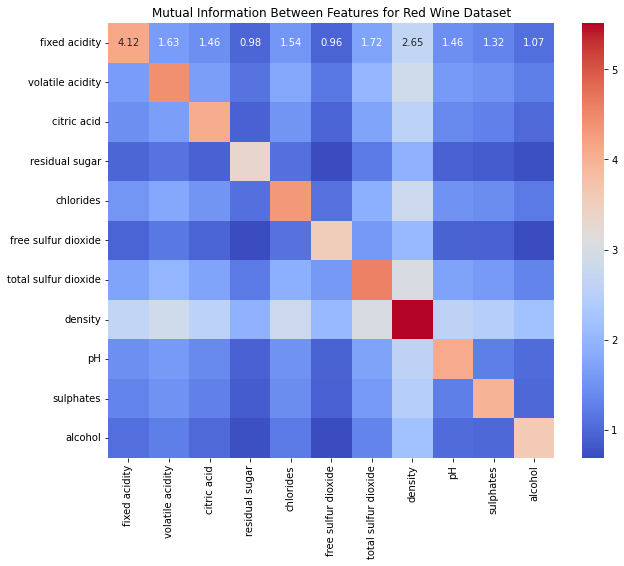

In [88]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mutual Information Between Features for Red Wine Dataset')
plt.show()

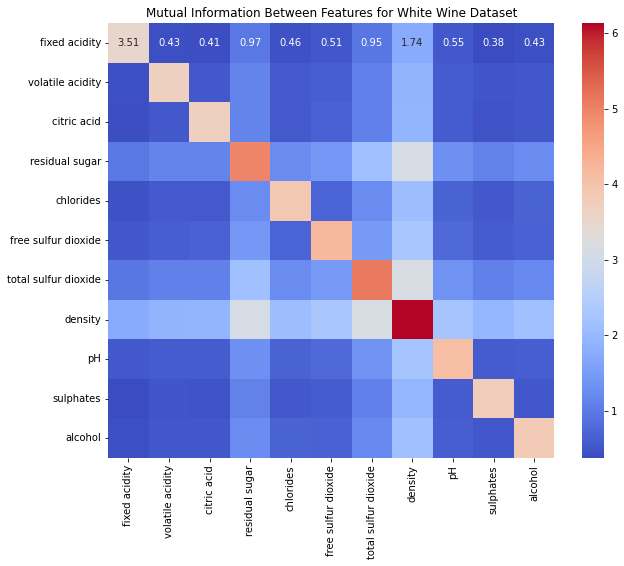

In [90]:
features = X_test.columns
mi_matrix = pd.DataFrame(index=features, columns=features, dtype=float)

for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features[i:], i):
        # Compute mutual information and fill both upper and lower triangle of the matrix
        mi_value = mutual_info_score(X_test[feature_i], X_test[feature_j])
        mi_matrix.at[feature_i, feature_j] = mi_value
        mi_matrix.at[feature_j, feature_i] = mi_value  # Since MI is symmetric

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(mi_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mutual Information Between Features for White Wine Dataset')
plt.show()

### PCA

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  # Red wine
X_test_scaled = scaler.transform(X_test)  # White wine, using the same scaler to ensure consistency


In [96]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)  # Transform red wine data
X_test_pca = pca.transform(X_test_scaled)  # Transform white wine data using the same PCA model


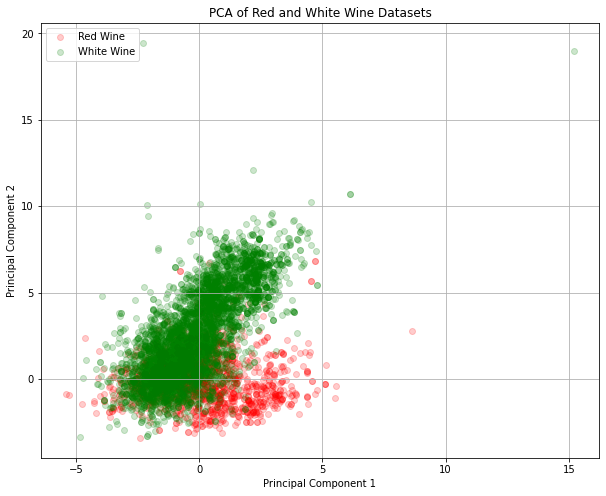

In [104]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.2, color='red', label='Red Wine')
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=0.2, color='green', label='White Wine')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Red and White Wine Datasets')
plt.legend()
plt.grid(True)
plt.show()


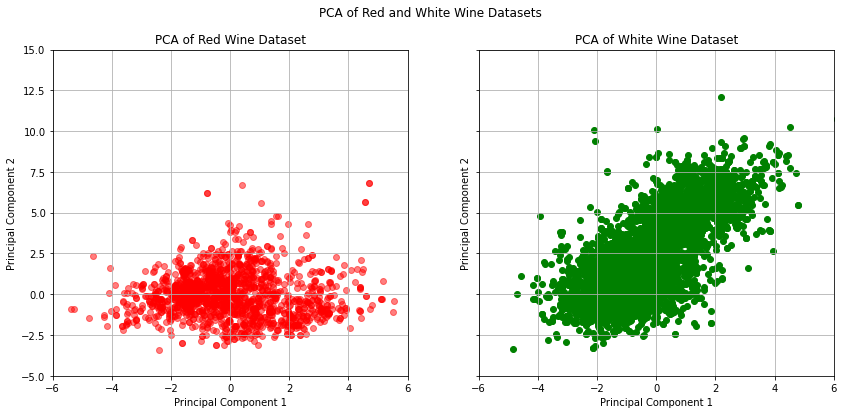

In [103]:
import matplotlib.pyplot as plt

# Creating a figure with two subplots (one for red wine, one for white wine), sharing the same x and y axes limits
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Plot PCA for Red Wine
ax[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5, color='red')
ax[0].set_title('PCA of Red Wine Dataset')
ax[0].set_xlim(-6, 6)  # Setting fixed x-axis limits
ax[0].set_ylim(-5, 15)  # Setting fixed y-axis limits
ax[0].grid(True)

# Plot PCA for White Wine
ax[1].scatter(X_test_pca[:, 0], X_test_pca[:, 1], alpha=1, color='green')
ax[1].set_title('PCA of White Wine Dataset')
ax[1].grid(True)

# Adding labels
for a in ax:
    a.set_xlabel('Principal Component 1')
    a.set_ylabel('Principal Component 2')

# Add a super title for the figure
plt.suptitle('PCA of Red and White Wine Datasets')

plt.show()
